In [1]:
from __future__ import division

import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import pylab as pyl
import time
import cvxpy as cp
from numpy import linalg as Lin
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import style
from sklearn import datasets

import warnings

warnings.filterwarnings('ignore')


%matplotlib inline
%load_ext autoreload
%autoreload 2

# Helper Functions

In [2]:
"""To compute distance matrix"""
def distmat(x,y):
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)


"""To Normalise a vector"""
normalize = lambda a: a/np.sum( a )

"""To Compute P"""
def GetP(u,K,v):
    return u[:,None]*K*v[None,:]

def plotp(plt, x, col, scale=200, edgecolors="k"):
  return plt.scatter(x[0,:], x[1,:], s=scale, edgecolors=edgecolors,  c=col, cmap='plasma', linewidths=2)


# Annulus vs Square

## Trying for different dimensions n x n

#### Generate Data

In [3]:
from sklearn.cluster import KMeans

In [4]:
def randomsampledata(N):
  x = []
  y = []
  N=np.sort(N)
  for i in range(len(N)):
    x.append(np.random.rand(2,N[i])-0.5)
    theta= 2*np.pi*np.random.rand(1,N[i])
    r = 0.8+0.2*np.random.rand(1,N[i])
    y.append(np.vstack((np.cos(theta)*r,np.sin(theta)*r)))
  
  return x,y,N

In [5]:
N = [ 200,400,600,800,1000 ]
x,y,N = randomsampledata(N)

### Linear Optimization

In [6]:
import computational_OT
#from linear import LinearOptimize

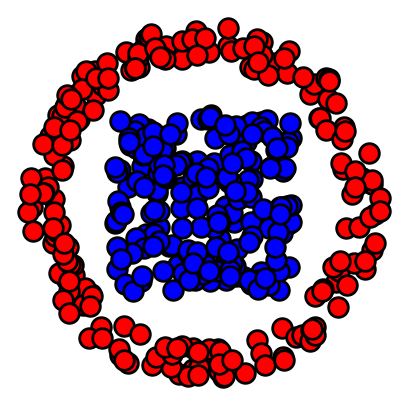

Doing for  200
 |- Iterating
 |- Computing P



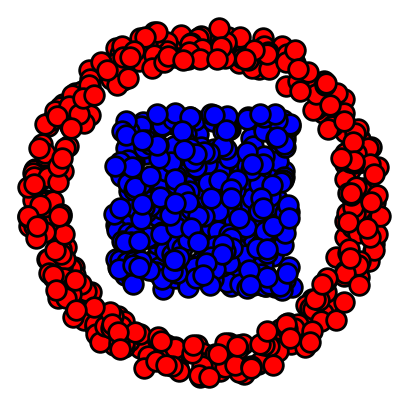

Doing for  400
 |- Iterating
 |- Computing P



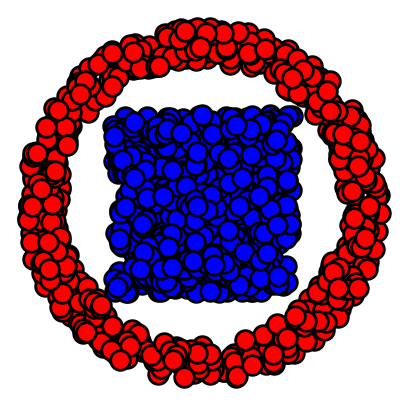

Doing for  600
 |- Iterating
 |- Computing P



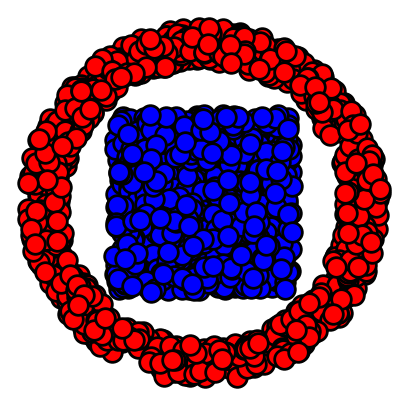

Doing for  800
 |- Iterating
 |- Computing P



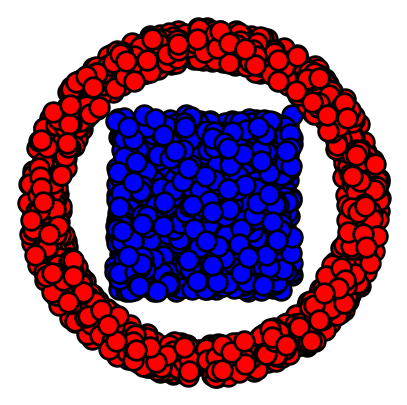

Doing for  1000
 |- Iterating
 |- Computing P



In [7]:
times_linearOpt = []
LinearP = []
for i in range(len(N)):
  xi,yi = x[i],y[i]
  #Cost matrix
  C = distmat(xi,yi)

  # a and b
  a = normalize(np.ones(N[i]))
  a = a.reshape(a.shape[0],-1)
  b = normalize(np.ones(N[i]))
  b = b.reshape(b.shape[0],-1)



  plt.figure(figsize=(5,5))

  plotp(plt,xi, col='b')
  plotp(plt,yi, col='r')

  plt.axis("off")
  plt.xlim(np.min(yi[0,:])-.1,np.max(yi[0,:])+.1)
  plt.ylim(np.min(yi[1,:])-.1,np.max(yi[1,:])+.1)

  plt.show()




  print("Doing for ",N[i])
  print( " |- Iterating")
  ### Linear Optimization
  start = time.time()
  Optimizer = computational_OT.LinearOptimize(N[i],N[i],a,b,C)
  print( " |- Computing P")
  print( "" )
  P_linear = Optimizer.solve()
  LinearP.append(P_linear.value)
  end = time.time()
  times_linearOpt.append(end-start)

 

### Sinkhorn

In [8]:
# Sinkhorn
print("Sinkhorn.... ")
SinkhornP = []
results_Sinkhorn = []
times_Sinkhorn = []
Pmatrix_dist_linVSsinkhorn = []
for i in range(len(N)):

  
  xi,yi = x[i],y[i]
  #Cost matrix
  C = distmat(xi,yi)
  
  # a and b
  a = normalize(np.ones(N[i]))
  a = a.reshape(a.shape[0],-1)
  b = normalize(np.ones(N[i]))
  b = b.reshape(b.shape[0],-1)
  
  #Epsilon
  epsilon = .06

  #Kernel
  K = np.exp(-C/epsilon)


  print("Doing for ",N[i])
  print( " |- Iterating")

  #Inflating
  u = a
  v = b

  start = time.time()
  Optimizer = computational_OT.Sinkhorn(K,a,b,u,v,epsilon)
  out = Optimizer._update()
  results_Sinkhorn.append(out)
  end = time.time()
  times_Sinkhorn.append(end-start)
  print( " |- Computing P")
  print( "" )
  SinkhornP.append(GetP(np.exp(out['potential_f']/epsilon),K,np.exp(out['potential_g']/epsilon)))
  

Sinkhorn.... 
Doing for  200
 |- Iterating
Terminating after iteration:  212
 |- Computing P

Doing for  400
 |- Iterating
Terminating after iteration:  173
 |- Computing P

Doing for  600
 |- Iterating
Terminating after iteration:  182
 |- Computing P

Doing for  800
 |- Iterating
Terminating after iteration:  175
 |- Computing P

Doing for  1000
 |- Iterating
Terminating after iteration:  178
 |- Computing P



##### Convergence plot for Sinkhorn

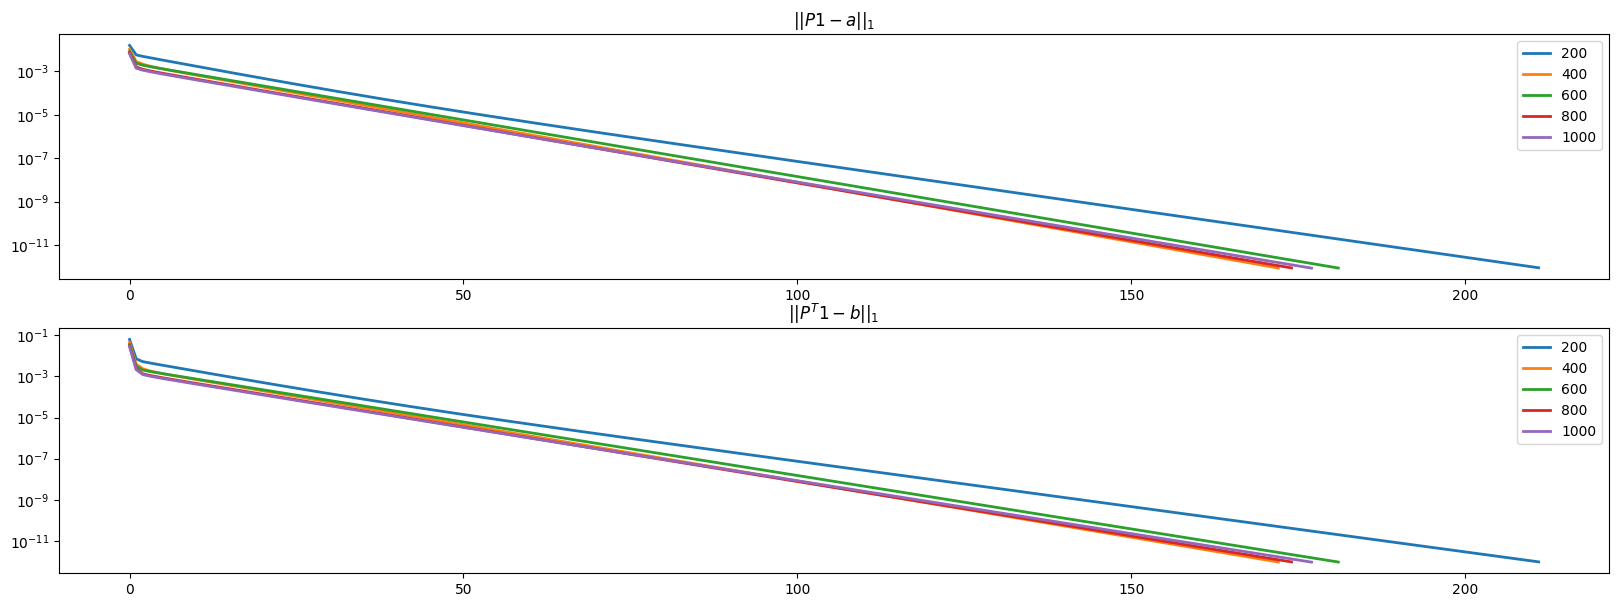

In [9]:
plt.figure(figsize = (20,7))

plt.subplot(2,1,1),
plt.title("$||P1 -a||_1$")
for result in results_Sinkhorn:
  plt.plot( np.asarray(result['error_a']), linewidth = 2)
plt.yscale( 'log')
plt.legend([str(i) for i in N],loc="upper right")

plt.subplot(2,1,2)
plt.title("$||P^T 1 -b||_1$")
for result in results_Sinkhorn:
  plt.plot( np.asarray(result['error_b']), linewidth = 2)
plt.yscale( 'log')
plt.legend([str(i) for i in N],loc="upper right")
plt.savefig("ConvergenceSink.png")
plt.show()

##### Objective Function

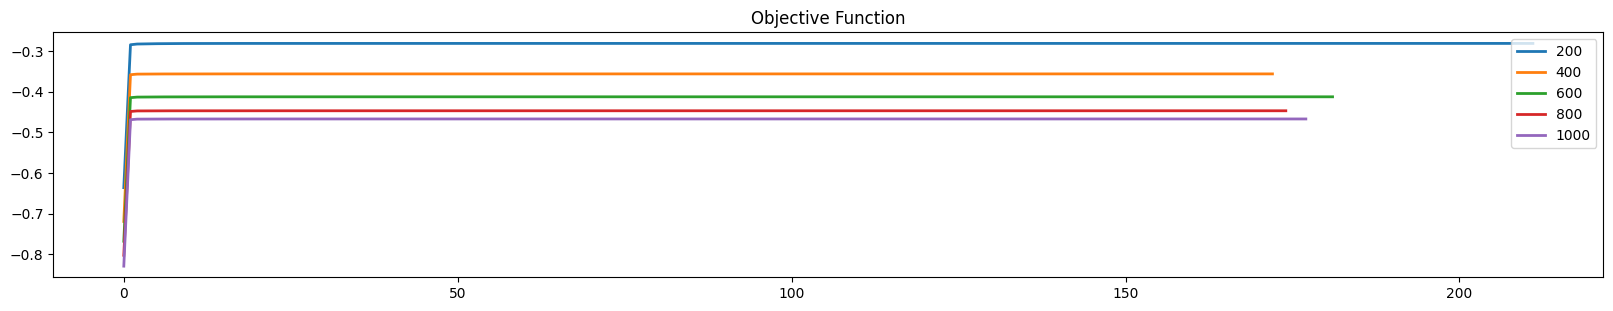

In [10]:
plt.figure(figsize = (20,7))
plt.subplot(2,1,1),
plt.title("Objective Function")


for result in results_Sinkhorn:
  plt.plot(np.asarray(result['objectives']).flatten(), linewidth = 2)
plt.legend([str(i) for i in N],loc="upper right")
plt.show()

### Gradient Ascent

In [11]:
learning_rate = 0.005

GradientAscentP = []
results_Gradient_ascent = []
times_Gradient_ascent = []
Pmatrix_dist_linVSgradientascent = []
Pmatrix_dist_sinkhornVSgradientascent = []

# Gradient ascent
print("Gradient ascent....")
results_Gradient_ascent = []
times_Gradient_ascent = []
for i in range(len(N)):

  xi,yi = x[i],y[i]
  #Cost matrix
  C = distmat(xi,yi)

  # a and b
  a = normalize(np.ones(N[i]))
  a = a.reshape(a.shape[0],-1)
  b = normalize(np.ones(N[i]))
  b = b.reshape(b.shape[0],-1)

  #Epsilon
  epsilon = .06

  #Kernel
  K = np.exp(-C/epsilon)
  
  f,g = a,b
  


  print("Doing for ",N[i])
  print( " |- Iterating")
  start = time.time()
  Optimizer = computational_OT.Gradient_Ascent(K,a,b,f,g,epsilon,learning_rate)
  out = Optimizer._update()
  results_Gradient_ascent.append(out)
  end = time.time()
  times_Gradient_ascent.append(end-start)
  print( " |- Computing P")
  print( "" )
  GradientAscentP.append(GetP(np.exp(out['potential_f']/epsilon),K,np.exp(out['potential_g']/epsilon)))
  


Gradient ascent....
Doing for  200
 |- Iterating
 |- Computing P

Doing for  400
 |- Iterating
 |- Computing P

Doing for  600
 |- Iterating
 |- Computing P

Doing for  800
 |- Iterating
 |- Computing P



##### Convergence plot for Gradient Ascent

In [ ]:
plt.figure(figsize = (20,7))
plt.subplot(2,1,1),
plt.title("$||P1 -a||_1$")

for result in results_Gradient_ascent:
  plt.plot(np.asarray(result['error_a']), linewidth = 2)
plt.yscale( 'log')
plt.legend([str(i) for i in N],loc="upper right")
plt.subplot(2,1,2)

plt.title("$||P^T 1 -b||_1$")
for result in results_Gradient_ascent:
  plt.plot(np.asarray(result['error_b']), linewidth = 2)
plt.yscale( 'log')
plt.legend([str(i) for i in N],loc="upper right")
plt.savefig("ConvergenceGrad.png")
plt.show()


##### Objective Function

In [ ]:
plt.figure(figsize = (20,7))
plt.subplot(2,1,1),
plt.title("Objective Function")


for result in results_Gradient_ascent:
  plt.plot(np.asarray(result['objectives']).flatten(), linewidth = 2)
plt.legend([str(i) for i in N],loc="upper right")
plt.show()

### Line Search

In [ ]:
rho = 0.95
rho_inc = 1.5
c1 = 0.05
c2 = 0.9
initial_alpha = 1

LineSearchP = []
results_LineSearch = []
times_LineSearch = []
Pmatrix_dist_linVSLineSearchP = []
Pmatrix_dist_sinkhornVSLineSearchP = []

Pmatrix_dist_GradientAscentVSLineSearchP = []


# Line Search
print("Line Search....")
for i in range(len(N)):

      xi,yi = x[i],y[i]
      #Cost matrix
      C = distmat(xi,yi)

      # a and b
      a = normalize(np.ones(N[i]))
      a = a.reshape(a.shape[0],-1)
      b = normalize(np.ones(N[i]))
      b = b.reshape(b.shape[0],-1)

      #Epsilon
      epsilon = .06

      #Kernel
      K = np.exp(-C/epsilon)


      f,g = a,b
              

      print("Doing for ",N[i])
      print( " |- Iterating")
      start = time.time()
      Optimizer = computational_OT.LineSearch(K,a,b,f,g,epsilon,rho,rho_inc,c1,c2,initial_alpha)
      out = Optimizer._update()
      results_LineSearch.append(out)
      end = time.time()
      times_LineSearch.append(end-start)
      print( " |- Computing P")
      print( "" )
      LineSearchP.append(GetP(np.exp(out['potential_f']/epsilon),K,np.exp(out['potential_g']/epsilon)))

     

##### Convergence plot for Line Search

In [ ]:
plt.figure(figsize = (20,7))
plt.title("$$")
plt.subplot(2,1,1),
plt.title("$||P1 -a||_1$")

for result in results_LineSearch:
  plt.plot(np.asarray(result['error_a']), linewidth = 2)
plt.yscale( 'log')
plt.legend([str(i) for i in N],loc="upper right")
plt.subplot(2,1,2)

plt.title("$||P^T 1 -b||_1$")
for result in results_LineSearch:
  plt.plot(np.asarray(result['error_b']), linewidth = 2)
plt.yscale( 'log')
plt.legend([str(i) for i in N],loc="upper right")
plt.savefig("convergenceLineSearch,png")
plt.show()

print("\n Error plots can increase! The error is not the objective function!")

##### Objective Function

In [ ]:
plt.figure(figsize = (20,7))
plt.subplot(2,1,1),
plt.title("Objective Function")


for result in results_LineSearch:
  plt.plot(np.asarray(result['objectives']), linewidth = 2)
#plt.yscale( 'log')
plt.legend([str(i) for i in N],loc="upper right")
plt.show()

##### Alpha plot

In [ ]:
plt.figure(figsize = (20,7))
plt.subplot(2,1,1),
plt.title("Alpha")

for result in results_LineSearch:
  plt.plot(np.asarray(result['linesearch_steps']), linewidth = 2)
#plt.yscale( 'log')

plt.legend([str(i) for i in N],loc="upper right")
plt.savefig("LineSearchAlpha.png")
plt.show()

#### For varying epsilons

In [ ]:
rho = 0.95
rho_inc = 1.5
c1 = 0.05
c2 = 0.9
initial_alpha = 1

LineSearchP = []
results_LineSearch = []
Pmatrix_dist_linVSLineSearchP = []
Pmatrix_dist_sinkhornVSLineSearchP = []
Pmatrix_dist_GradientAscentVSLineSearchP = []

epsilons = [ 0.01,0.05,0.08,0.1 ]
for eps in epsilons:

    # Line Search
    print("Line Search....")    


    #Cost matrix
    C = distmat(x[1],y[1])


    # a and b
    a = normalize(np.ones(N[1]))
    a = a.reshape(a.shape[0],-1)
    b = normalize(np.ones(N[1]))
    b = b.reshape(b.shape[0],-1)

    #Epsilon 




    # epsilon = .05

    #Kernel
    K = np.exp(-C/eps)


    f,g = a,b
            

    print("Doing for (",N[1],N[1],").")
    print( " |- Iterating")
    start = time.time()
    Optimizer = computational_OT.LineSearch(K,a,b,f,g,eps,rho,rho_inc,c1,c2,initial_alpha)
    out = Optimizer._update(maxiter=1000)
    results_LineSearch.append(out)
    end = time.time()
    print( " |- Computing P")
    print( "" )
    LineSearchP.append(GetP(np.exp(out['potential_f']/eps),K,np.exp(out['potential_g']/eps)))


In [ ]:
# Plot
plt.figure(figsize = (15,6))
n=len(results_LineSearch)
#plt.subplot(2,1,1),
plt.title("$||P1 -a||_1 + ||P^T 1 -b||_1$")
for i in range(n):
    error_hybrid   = np.asarray(results_LineSearch[i]['error_a']) + np.asarray(results_LineSearch[i]['error_b'])
    plt.plot( error_hybrid,label='LineSearch for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Error in log-scale")
plt.legend()
plt.yscale( 'log')
plt.savefig("Linesearchvaryingepsilon.png")
plt.show()

In [ ]:
plt.figure(figsize = (20,7))
plt.subplot(2,1,1),
plt.title("Alpha")

for i in range(len(results_LineSearch)):
  plt.plot( np.asarray(results_LineSearch[i]['linesearch_steps']),label='LineSearchNewton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Alpha in log-scale")
plt.legend()
# plt.yscale( 'log')
plt.savefig("AlphaLineSearchNewton.png")
plt.show()



### L_BFGS_B

In [ ]:
BFGSP = []
results_BFGS = []

times_BFGS = []
Pmatrix_dist_linVSBFGSP = []
Pmatrix_dist_sinkhornVSBFGSP = []
Pmatrix_dist_GradientAscentVSBFGSP = []

# BFGS
print("BFGS....")

for i in range(len(N)):

      xi,yi = x[i],y[i]
      #Cost matrix
      C = distmat(xi,yi)
      # a and b
      a = normalize(np.ones(N[i]))
      a = a.reshape(a.shape[0],-1)
      b = normalize(np.ones(N[i]))
      b = b.reshape(b.shape[0],-1)

      #Epsilon
      epsilon = .06

      #Kernel
      K = np.exp(-C/epsilon)


      f,g = a,b


      print("Doing for ",N[i])
      print( " |- Iterating")
      start = time.time()
      Optimizer = computational_OT.L_BFGS_B(K,a,b,f,g,epsilon)
      out = Optimizer._update()
      results_BFGS.append(out)
      end = time.time()
      times_BFGS.append(end-start)
      print( " |- Computing P")
      print( "" )
      BFGSP.append(GetP(np.exp(out['potential_f']/epsilon),K,np.exp(out['potential_g']/epsilon)))

     

##### Convergence plot for L-BFGS-B

In [ ]:
plt.figure(figsize = (20,7))
plt.title("$$")
plt.subplot(2,1,1),
plt.title("$||P1 -a||_1$")

for result in results_BFGS:
  plt.plot(np.asarray(result['error_a']), linewidth = 2)
plt.yscale( 'log')
plt.legend([str(i) for i in N],loc="upper right")
plt.subplot(2,1,2)

plt.title("$||P^T 1 -b||_1$")
for result in results_BFGS:
  plt.plot(np.asarray(result['error_b']), linewidth = 2)
plt.yscale( 'log')
plt.legend([str(i) for i in N],loc="upper right")
plt.savefig("LBFGSconvergence.png")
plt.show()

print("\n Error plots can increase! The error is not the objective function!")

##### Objective Function

In [ ]:
plt.figure(figsize = (20,7))
plt.subplot(2,1,1),
plt.title("Objective Function")


for result in results_BFGS:
  plt.plot(np.asarray(result['objectives']), linewidth = 2)
#plt.yscale( 'log')
plt.legend([str(i) for i in N],loc="upper right")
plt.show()

#### For varying epsilons

In [ ]:
BFGSP = []
results_BFGS = []

Pmatrix_dist_linVSBFGSP = []
Pmatrix_dist_sinkhornVSBFGSP = []
Pmatrix_dist_GradientAscentVSBFGSP = []
epsilons = [ 0.01,0.02,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5 ]

# BFGS
print("BFGS....")
N = (400,400)
for eps in epsilons:


      #Cost matrix
      C = distmat(x[1],y[1])
      # a and b
      a = normalize(np.ones(N[1]))
      a = a.reshape(a.shape[0],-1)
      b = normalize(np.ones(N[1]))
      b = b.reshape(b.shape[0],-1)

  

      #Kernel
      K = np.exp(-C/eps)


      f,g = a,b


      print("Doing for ",(N[1],N[1]))
      print("\n Epsilon: " +str(eps))
      
      print( " |- Iterating")
      start = time.time()
      Optimizer = computational_OT.L_BFGS_B(K,a,b,f,g,eps)
      out = Optimizer._update()
      results_BFGS.append(out)
      end = time.time()
      print( " |- Computing P")
      print( "" )
      BFGSP.append(GetP(np.exp(out['potential_f']/epsilon),K,np.exp(out['potential_g']/epsilon)))

     

In [ ]:
plt.figure(figsize = (20,7))
plt.title("$$")
plt.title("$||P1 -a||_1+||P^T 1 -b||_1$")

for result in results_BFGS:
  error=np.asarray(result['error_a'])+np.asarray(result['error_b'])
  plt.plot( error,label='LBGFS for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)
plt.yscale( 'log')
plt.savefig("LBGFSvaryepsilon.png")
plt.show()